# FM Modulation

### In this notebook I do some experiments on an analog signal sampled and modulated then demodulated. I visualize the signal in time and frequency domains and test the effect of fm modulation on the signal.

In [375]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import stem
import numpy as np
from scipy import integrate
from scipy.signal import firwin, kaiser_atten, kaiser_beta , freqz , lfilter

from scipy.fft import fft, fftfreq, fftshift , ifft
import IPython

In [376]:
plt.rcParams["figure.figsize"] = (18,4)

Then, since we're playing audio, we need to set the internal "clock" of the system, aka the sampling rate:

In [377]:
Fs = 16000 # 16 KHz sampling rate
Ts = 1/Fs

In [378]:
### We first examine the FM narrow-band simplified equation and compare it with the original formula.

###   Narrow-Band Modulation [Simplified Formula]
![Title](Narrow-Band%20Phase_Modulator.png)

### Wide-Band Modulation [Original Formula]
![orginial](org_formula.png)

In [447]:
# Define the Signal and Carrier Parameters
Ac , Am = 1 , 1
Fc , Fm = 200 , 10
Wc , Wm = 2*np.pi*Fc , 2*np.pi*Fm
Kf = 7

t = np.arange(0, 5/Fm , Ts) # 5-cycles of the modulating signal

dev_f = Kf*Am
Beta = dev_f/Fm

Message_Bandwidth = Fm


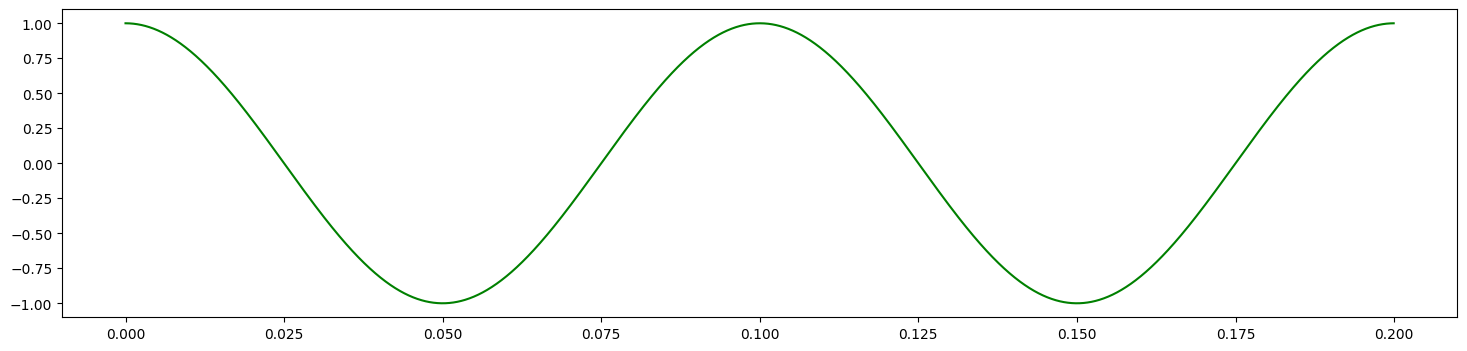

In [380]:
Msg = Am * np.cos(Wm * t)

plt.plot(t,Msg,'g')

## Original Modulated Signal

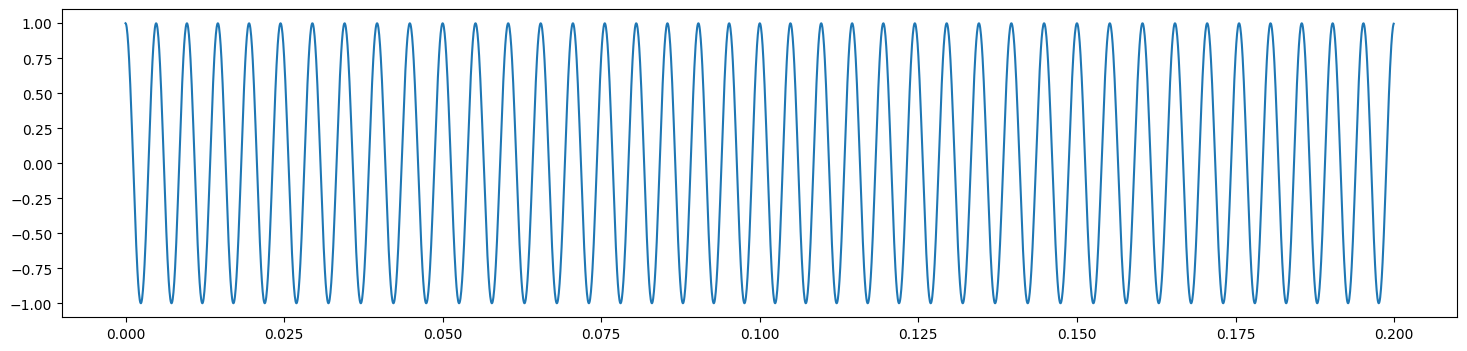

In [381]:
Msg_int = integrate.cumtrapz(Msg, t, initial=0)

S_org = Ac * np.cos( Wc*t + 2*np.pi*Kf*Msg_int  )

plt.plot(t,S_org)

## Simplified Modulated Signal

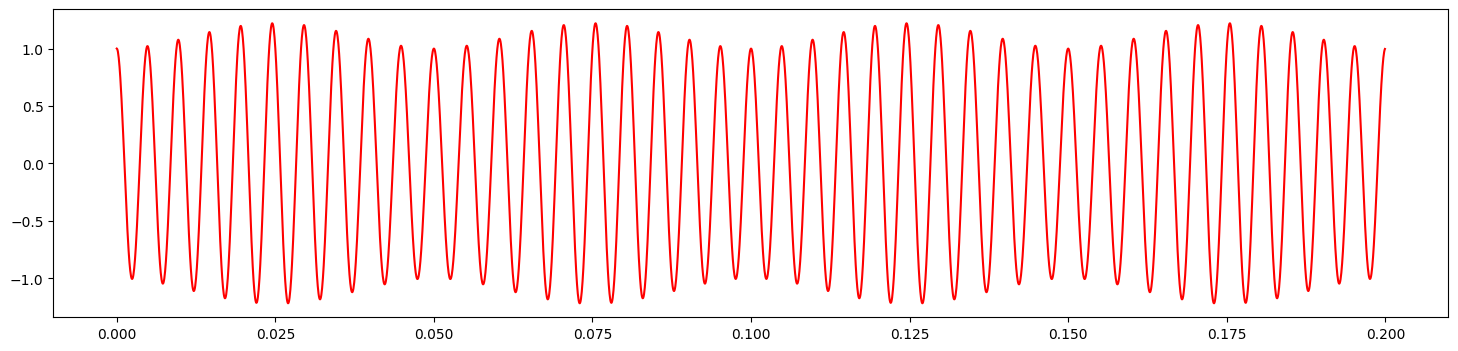

In [382]:
S_simp = Ac * np.cos( 2*np.pi*Fc*t ) - Beta * Ac * np.sin(2*np.pi*Fc*t) * np.sin(2*np.pi*Fm*t)

plt.plot(t,S_simp,'r')

#### Notice that as the Beta factor increases the simplified version deviates from the original version of the FM modulation.

## Fequency Domain of the Modulated Signals

<StemContainer object of 3 artists>

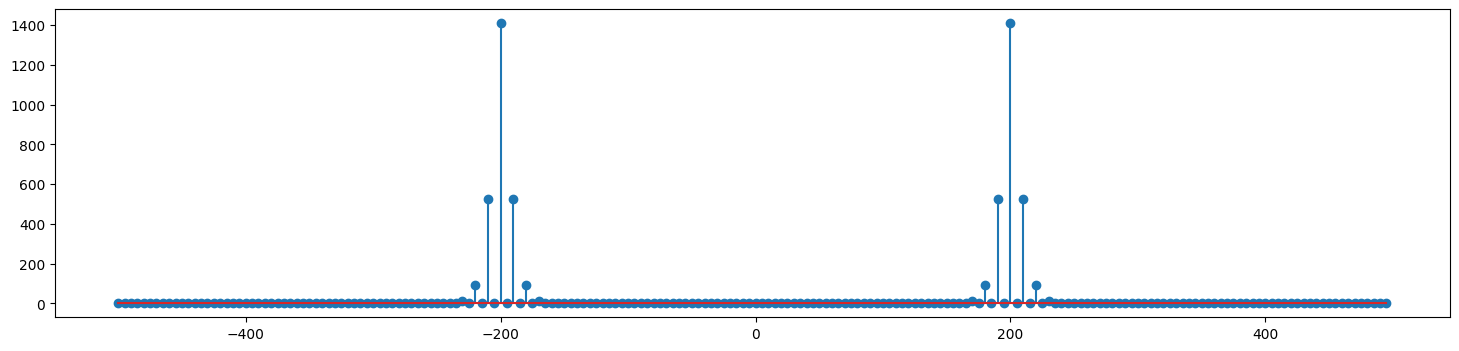

In [383]:
 # The original
spectrum_org = fftshift(np.abs(fft(S_org)))
freq = fftshift(fftfreq(spectrum_org.size, Ts))

c = int(freq.size/2)
f1 , f2 = c - 100 , c + 100

stem(freq[f1:f2] ,spectrum_org[f1:f2])


<StemContainer object of 3 artists>

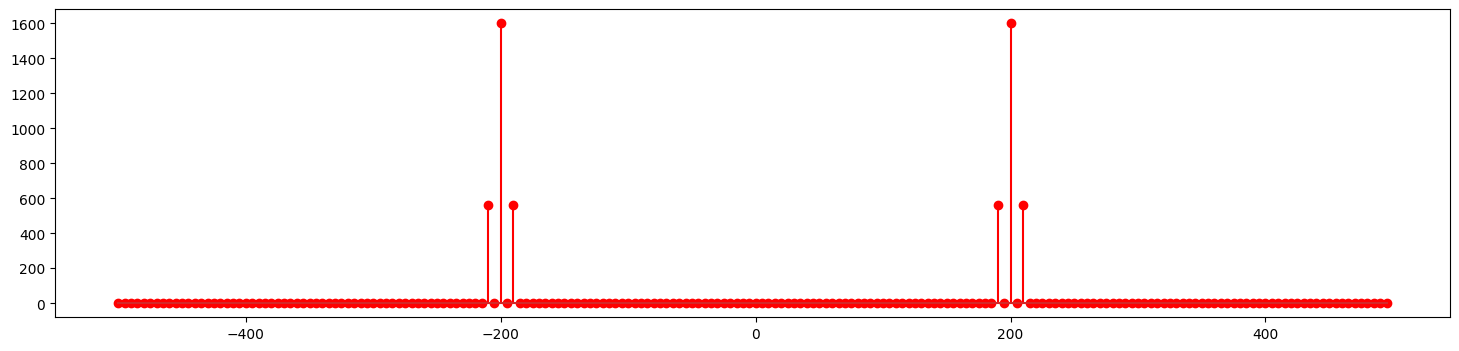

In [384]:
# Simplified
spectrum_simp = fftshift(np.abs(fft(S_simp)))
stem(freq[f1:f2] ,spectrum_simp[f1:f2],'r')

#### Notice that the simplified version (Narrow Band) spectrum is not identical to the spectrum of the original Signal.

## Now we up to design the Wide-Band Modulator using the ARMSTRONG Method

![Title](Armstrong_Modulator.png)



#### We have already done with Narrow-Band frequency Modulator , and the job now is to simulate the Frequency Multiplier.

![Title](Frequency_Multiplier.png)

### We start by the band-pass filter

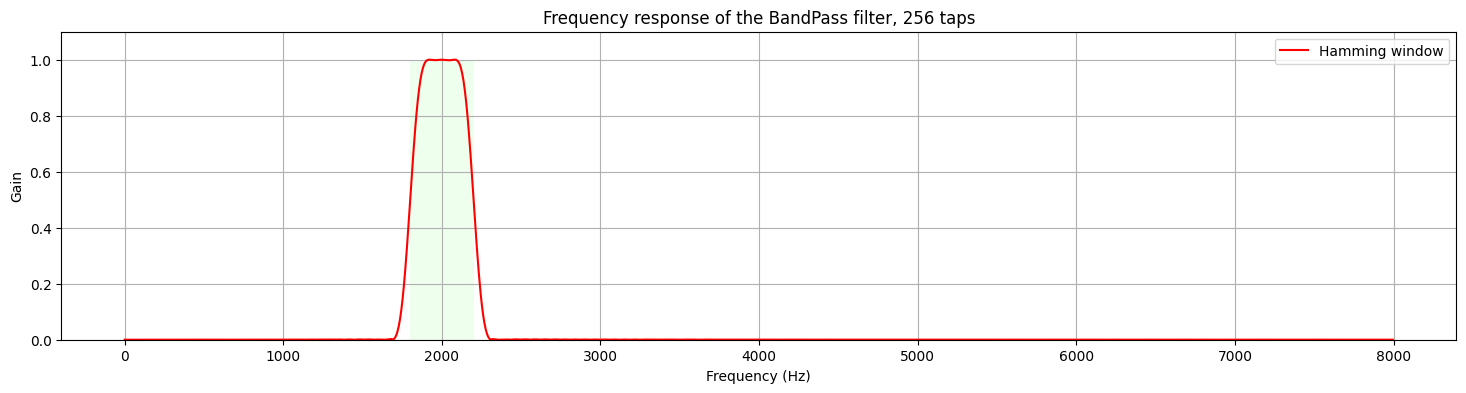

In [455]:
lowcut =  1800
highcut = 2200

ntaps = 256

taps = firwin(ntaps, [lowcut, highcut], fs= Fs , pass_zero= False,
              window='hamming', scale=True)


# First plot the desired ideal response as a green(ish) rectangle.
rect = plt.Rectangle((lowcut, 0), highcut - lowcut, 1.0,
                     facecolor="#60ff60", alpha=0.1)
plt.gca().add_patch(rect)

# Plot the frequency response of the filter.
w, h = freqz(taps, 1, worN=2000 , fs= Fs)
plt.plot( w, abs(h), 'r', label="Hamming window" )

plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency response of the BandPass filter, %d taps' % ntaps)
plt.show()


In [436]:
def freq_multiplier(signal, fc ,bandwidth  , n):
    v = signal
    for i in range(2,n+1):
        v = v + (signal ** i)

    lowcut =  n*fc - (bandwidth*n)/2
    highcut = n*fc + (bandwidth*n)/2

    taps = firwin( numtaps = 256, cutoff = [lowcut, highcut], fs= Fs , pass_zero = "bandpass", scale=False)

    return lfilter(taps,1,v)


array([ 3.77111800e-04,  5.41035410e-04,  3.60856442e-04, ...,
       -4.45211500e-05, -5.49587004e-05, -6.53242750e-05])

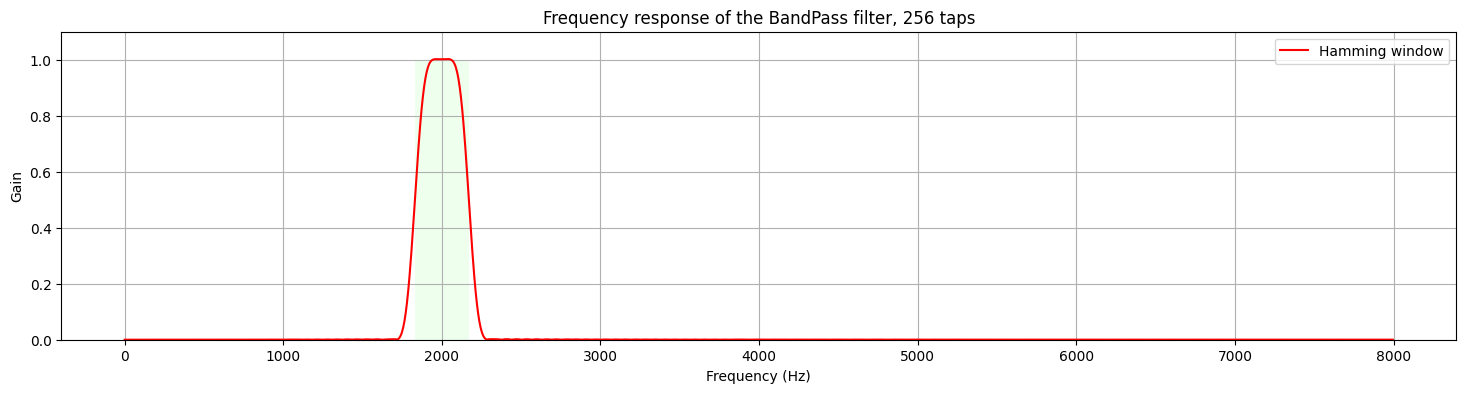

In [431]:
Bt = 2 * (dev_f + Message_Bandwidth)
freq_multiplier(S_simp , fc= Fc , bandwidth= Bt , n = 10)

## Now Lets define the modulator function that works with Armstrong method

In [433]:
def fm_armstrong_modulate(signal: np.ndarray, fc , fs , bandwidth ):
    # first we find the maximum of the signal envelop
    Am = max(abs(np.max(signal)),abs(np.min(signal)))

    # bandwidth * Beta = Kf * Am   .. Let Beta as small as 0.1 then
    Kf = (bandwidth * 0.1)/Am

    Ts = 1/fs
    t = np.arange(0, signal.size * Ts , Ts)
    integrated_signal = integrate.cumtrapz(signal, t, initial=0)
    # now we had to calculate the narrow-band modulated signal, so we have to scale the carrier frequency to low value
    # we make sure that the scale factor n at least asure that fc is at least 10 times the signal bandwidth, hence   fc / n  >  100 * bandwidth
    n = int ( np.floor( fc / (10 * bandwidth) ) )
    fc_n = fc / n
    Wc = 2 * np.pi * fc_n
    # narrow-band signal
    narrow_fm = np.cos(Wc * t) - np.sin(Wc * t) * 2 * np.pi * Kf * integrated_signal

    # Now we pass the narrow-band signal to the frequency multiplier
    freq_deviation = Kf * Am
    Bt = 2 * (freq_deviation + bandwidth)
    # and return the output signal
    return freq_multiplier(narrow_fm, fc_n , Bt , n)




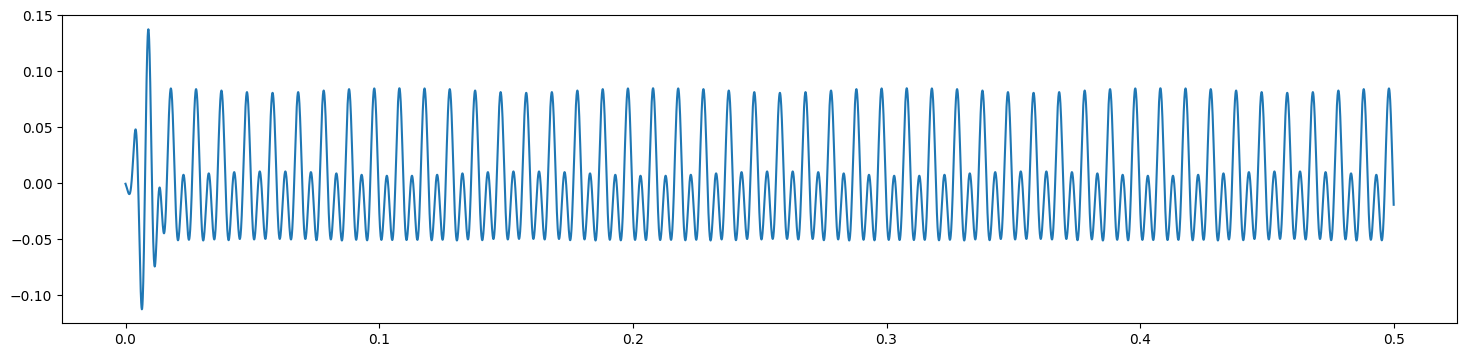

In [491]:
msg = np.cos(2*np.pi*10*t)
s = fm_armstrong_modulate(msg,Fc,Fs,Fm)
plt.cla()
plt.plot(t,s)

